In [1]:
import pandas as pd
session_test_df = pd.read_csv('/app/data/EncryptedTrafficFeatureDatasetforMachineLearningandDeepLearningbasedEncryptedTrafficAnalysis/TestSet/session_based_testset.csv')
session_train_df = pd.read_csv('/app/data/EncryptedTrafficFeatureDatasetforMachineLearningandDeepLearningbasedEncryptedTrafficAnalysis/TestSet/session_based_testset.csv')

In [9]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn --break-system-packages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 22.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 21.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 18.9 MB/s eta 0:00

In [4]:
session_train_df.drop(['unique_link_mark'], axis=1, inplace=True, errors='ignore')
session_test_df.drop(['unique_link_mark'], axis=1, inplace=True, errors='ignore')

session_train_df.fillna(session_train_df.median(), inplace=True)
session_test_df.fillna(session_test_df.median(), inplace=True)

X_train = session_train_df.drop('label', axis=1)
y_train = session_train_df['label']

X_test = session_test_df.drop('label', axis=1)
y_test = session_test_df['label']

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:15:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


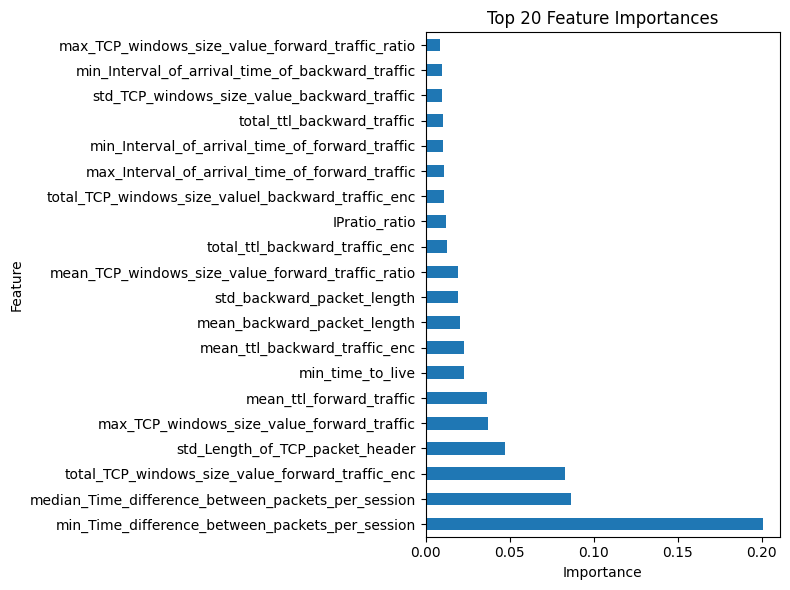

In [5]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt

model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_xgb.fit(X_train, y_train)

importance = model_xgb.feature_importances_
features = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
selected_features = features.head(20).index.tolist()
features.head(20).plot(kind='barh', figsize=(8, 6))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


## RandomForest & XGBoost

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train_selected, y_train)
y_pred_rf = rf_clf.predict(X_test_selected)

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train_selected, y_train)
y_pred_xgb = xgb_clf.predict(X_test_selected)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:16:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## IsolationForest

In [8]:
from sklearn.ensemble import IsolationForest
import numpy as np

iso_forest = IsolationForest(contamination=0.05, random_state=42)
iso_forest.fit(X_train[y_train == 0])

y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso == 1, 0, 1)


In [9]:
print('Random Forest Model Evaluation')
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_rf))

print('\nXGBoost Model Evaluation')
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_xgb))

print('\nIsolation Forest (Zero-shot detection) Evaluation')
print(classification_report(y_test, y_pred_iso))
print(confusion_matrix(y_test, y_pred_iso))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_iso))

Random Forest Model Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61273
           1       1.00      1.00      1.00     60859

    accuracy                           1.00    122132
   macro avg       1.00      1.00      1.00    122132
weighted avg       1.00      1.00      1.00    122132

[[61273     0]
 [    0 60859]]
ROC-AUC: 1.0

XGBoost Model Evaluation
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61273
           1       1.00      1.00      1.00     60859

    accuracy                           1.00    122132
   macro avg       1.00      1.00      1.00    122132
weighted avg       1.00      1.00      1.00    122132

[[61268     5]
 [   22 60837]]
ROC-AUC: 0.9997784533366669

Isolation Forest (Zero-shot detection) Evaluation
              precision    recall  f1-score   support

           0       0.51      0.95      0.66     61273
           1       0.56   

In [10]:
import joblib

joblib.dump(rf_clf, 'random_forest_model.pkl')
joblib.dump(xgb_clf, 'xgboost_model.pkl')
joblib.dump(iso_forest, 'isolation_forest_model.pkl')

['isolation_forest_model.pkl']